In [ ]:
!apt-get update #depolama alanı güncelleme

In [ ]:
%pwd #adres öğrenme

In [ ]:
!chmod +x /content #izin alma 

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [173]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [ ]:
import xgboost 
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import catboost
from catboost import CatBoostClassifier

In [185]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditcard_approvals/cc_approvals.csv")

In [186]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriverLicence,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,1
2,a,24.5,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,1


In [187]:
df["Approved"].value_counts()

0    383
1    307
Name: Approved, dtype: int64

In [188]:
df.describe().T #b.sız degiskenlerin betimsel istatistiği

,count,mean,std,min,25%,50%,75%,max
Debt,690.0,4.758725,4.978163,0.0,1.000,2.75,7.2075,28.0
YearsEmployed,690.0,2.223406,3.346513,0.0,0.165,1.00,2.6250,28.5
CreditScore,690.0,2.400000,4.862940,0.0,0.000,0.00,3.0000,67.0
Income,690.0,1017.385507,5210.102598,0.0,0.000,5.00,395.5000,100000.0
Approved,690.0,0.444928,0.497318,0.0,0.000,0.00,1.0000,1.0


In [189]:
df = df.replace("?", np.nan)

In [190]:
df.fillna(df.mean(), inplace = True) #eksik degerler
df.isna().sum()

Gender            12
Age               12
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriverLicence      0
Citizen            0
ZipCode           13
Income             0
Approved           0
dtype: int64

In [191]:
for i in df:
    if df[i].dtypes == "object":
        df = df.fillna(df[i].value_counts().index[0])
        
df.isna().sum() #eksik degerler giderildi

Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriverLicence     0
Citizen           0
ZipCode           0
Income            0
Approved          0
dtype: int64

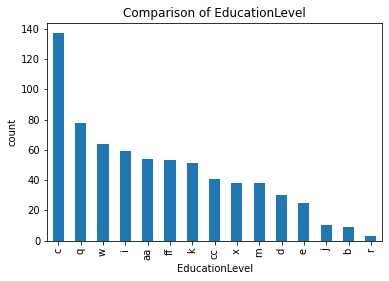

In [192]:
df['EducationLevel'].value_counts(normalize = True)
df['EducationLevel'].value_counts(dropna = False).plot.bar()
plt.title('Comparison of EducationLevel')
plt.xlabel('EducationLevel')
plt.ylabel('count')
plt.show()

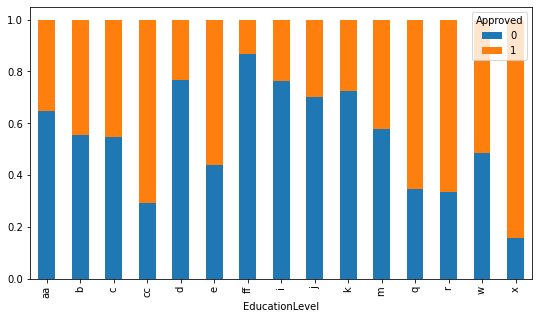

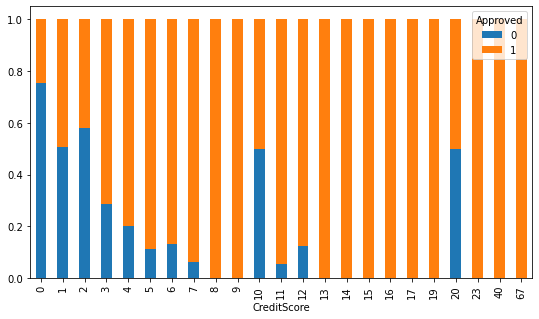

In [193]:
x = pd.crosstab(df['EducationLevel'], df['Approved'])
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (9, 5))
x = pd.crosstab(df['CreditScore'], df['Approved'])
x.div(x.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (9, 5))

In [194]:
le = LabelEncoder()
for i in df:
    if df[i].dtypes == "object":
       df[i] = le.fit_transform(df[i]) #sayısal olmayan değerleri sayısal değerlere dönüştür

In [195]:
df = df.drop(['DriverLicence', 'ZipCode'], axis = 1)

In [196]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,156,0.000,2,1,13,8,1.25,1,1,1,0,0,1
1,0,328,4.460,2,1,11,4,3.04,1,1,6,0,560,1
2,0,89,0.500,2,1,11,4,1.50,1,0,0,0,824,1
3,1,125,1.540,2,1,13,8,3.75,1,1,5,0,3,1
4,1,43,5.625,2,1,13,8,1.71,1,0,0,2,0,1


In [197]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)

In [198]:
y #b.lı degisken

0      1
1      1
2      1
3      1
4      1
      ..
685    0
686    0
687    0
688    0
689    0
Name: Approved, Length: 690, dtype: int64

In [199]:
X #b.sız degisken

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income
0,1,156,0.000,2,1,13,8,1.25,1,1,1,0,0
1,0,328,4.460,2,1,11,4,3.04,1,1,6,0,560
2,0,89,0.500,2,1,11,4,1.50,1,0,0,0,824
3,1,125,1.540,2,1,13,8,3.75,1,1,5,0,3
4,1,43,5.625,2,1,13,8,1.71,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,52,10.085,3,3,5,4,1.25,0,0,0,0,0
686,0,71,0.750,2,1,2,8,2.00,0,1,2,0,394
687,0,97,13.500,3,3,6,3,2.00,0,1,1,0,1
688,1,20,0.205,2,1,0,8,0.04,0,0,0,0,750


# Logistik Regression

### Model & Tahmin

In [200]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [201]:
log_model = LogisticRegression(solver = "liblinear").fit(X_train,y_train)

In [202]:
log_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_model.intercept_

In [ ]:
log_model.coef_

In [ ]:
log_model.predict(X_train)[0:10] #basitce tahmin edilen y degerleri 

In [ ]:
log_model.predict(X_test)[0:10]

In [203]:
y_pred = log_model.predict(X_test) #tahmin degerleri y_prede atandi

In [204]:
confusion_matrix(y_test, y_pred) #karmasiklik matrisiyle model basarisi degerlendirmesi 

array([[89, 21],
       [11, 86]])

In [205]:
accuracy_score(y_test,y_pred) #dogruluk orani, basarili tahmin/tum durum

0.8454106280193237

### Model Tuning (Doğrulama)

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
log_model = LogisticRegression(solver = "liblinear").fit(X_train,y_train)
log_model

In [ ]:
log_params = {"tol":[0.01, 0.001, 0.0001],
              "max_iter":[100, 150, 200]}

In [207]:
log_cv_model = GridSearchCV(log_model, log_params, cv=10).fit(X_train, y_train)

In [208]:
log_cv_model.best_params_

{'max_iter': 100, 'tol': 0.0001}

In [209]:
y_pred = log_model.predict(X_test) #tahmin degerleri y_prede atandi

In [210]:
accuracy_score(y_test,y_pred) #dogruluk orani, basarili tahmin/tum durum

0.8454106280193237

#KNN (k-nearest neighbours)


### Model & Tahmin


In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [211]:
knn_model = KNeighborsClassifier().fit(X_train, y_train)

In [ ]:
knn_model

In [212]:
y_pred = knn_model.predict(X_test)

In [214]:
accuracy_score(y_test, y_pred)

0.6714975845410628

### Model Tuning


In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
knn= KNeighborsClassifier()

In [ ]:
knn_params = {"n_neighbors": np.arange(1, 50)}

In [ ]:
knn_cv_model = GridSearchCV(knn, knn_params, cv=10).fit(X_train, y_train)

In [ ]:
knn_cv_model.best_score_

In [ ]:
knn_cv_model.best_params_

In [216]:
#final model
knn_tuned = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

In [217]:
y_pred = knn_tuned.predict(X_test)

In [218]:
accuracy_score(y_test, y_pred)

0.6714975845410628

# Support Vector Machines (SVM)

### Model & Tahmin

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
svm_model = SVC(kernel="linear").fit(X_train, y_train)

In [ ]:
svm_model

In [220]:
y_pred = svm_model.predict(X_test)

In [221]:
accuracy_score(y_test,y_pred)

0.8405797101449275

### Model Tuning

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
svm = SVC()

In [ ]:
svm_params = {"C": np.arange(1,5), "kernel": ["linear", "rbf"]}

In [ ]:
svm_cv_model = GridSearchCV(svm, svm_params, cv=5, n_jobs=-1, verbose=2).fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 53.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 56.7min finished


In [ ]:
svm_cv_model.best_params_

{'C': 1, 'kernel': 'linear'}

In [ ]:
#final model
svm_tuned = SVC(C=1, kernel="linear").fit(X_train, y_train)

In [ ]:
y_pred = svm_tuned.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

0.8405797101449275

# Yapay sinir ağları

### Model & Tahmin

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [ ]:
scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [ ]:
mlpc_model = MLPClassifier().fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
mlpc_model

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlpc_model.coefs_

In [ ]:
y_pred = mlpc_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8599033816425121

### Model Tuning

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
mlpc_params = {"alpha": [1, 5, 0.1, 0.03],
               "hidden_layer_sizes": [(10,10), (3,5)]}

In [ ]:
mlpc = MLPClassifier(solver = "lbfgs", activation="logistic")

In [ ]:
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mlpc_cv_model.best_params_

{'alpha': 1, 'hidden_layer_sizes': (3, 5)}

In [ ]:
#final model
mlpc_tuned = MLPClassifier(solver = "lbfgs", activation="logistic", alpha=1, hidden_layer_sizes=(3,5) ).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mlpc_tuned

MLPClassifier(activation='logistic', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
y_pred = mlpc_tuned.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8309178743961353

# CART

###Model & Tahmin 

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
cart_model = DecisionTreeClassifier().fit(X_train, y_train)

In [ ]:
cart_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = cart_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8405797101449275

###Model Tuning

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
cart = DecisionTreeClassifier()

In [ ]:
cart_params = {"max_depth": [1,3,5,8,10],
               "min_samples_split": [2,3,5,10]}

In [ ]:
cart_cv_model = GridSearchCV(cart, cart_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.9s finished


In [ ]:
cart_cv_model.best_params_

{'max_depth': 1, 'min_samples_split': 2}

In [222]:
#final model
cart_tuned = DecisionTreeClassifier(max_depth = 1, min_samples_split = 2 ).fit(X_train, y_train)

In [223]:
y_pred = cart_tuned.predict(X_test)

In [224]:
accuracy_score(y_test, y_pred)

0.8405797101449275

# Random Forests

###Model & Tahmin 

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.855072463768116

### Model Tuning

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf_params = {"n_estimators": [100,200,500],
             "max_features" : [3,5,7,8],
             "min_samples_split": [2,5,10,20],
             }

In [ ]:
rf_cv_model = GridSearchCV(rf, rf_params,cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.0min finished


In [ ]:
rf_cv_model.best_params_

{'max_features': 7, 'min_samples_split': 2, 'n_estimators': 500}

In [225]:
rf_tuned = RandomForestClassifier(max_features = 5, min_samples_split = 10, n_estimators = 500 ).fit(X_train, y_train)

In [226]:
y_pred = rf_tuned.predict(X_test)

In [227]:
accuracy_score(y_test, y_pred)

0.8888888888888888

### Değisken Önem Düzeyleri

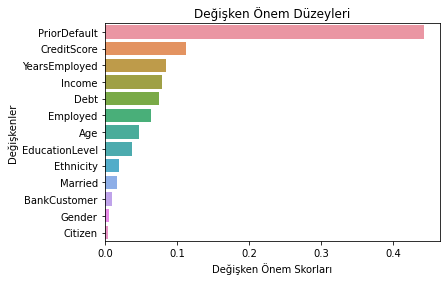

In [ ]:
feature_imp = pd.Series(rf_tuned.feature_importances_,
                        index = X_train.columns).sort_values(ascending=False)
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Değişken Önem Skorları")
plt.ylabel("Değişkenler")
plt.title("Değişken Önem Düzeyleri")
plt.show()

# Gradient Boosting Machines (GBM)

### Model & Tahmin

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
gbm_model = GradientBoostingClassifier().fit(X_train, y_train)
gbm_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = gbm_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8695652173913043

### Model Tuning

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
gbm = GradientBoostingClassifier()

In [ ]:
gbm_params = {"learning_rate": [0.1,0.01,0.001,0.5],
              "max_depth": [2,3,5,8],
              "n_estimators": [100,300,500,1000]}

In [ ]:
gbm_cv_model = GridSearchCV(gbm, gbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  5.1min finished


In [ ]:
gbm_cv_model.best_params_

In [228]:
gbm_tuned = GradientBoostingClassifier(learning_rate= 0.5, max_depth = 5, n_estimators= 100 ).fit(X_train, y_train)

In [229]:
y_pred = gbm_tuned.predict(X_test)

In [230]:
accuracy_score(y_test, y_pred)

0.855072463768116

### Değisken Önem Düzeyleri

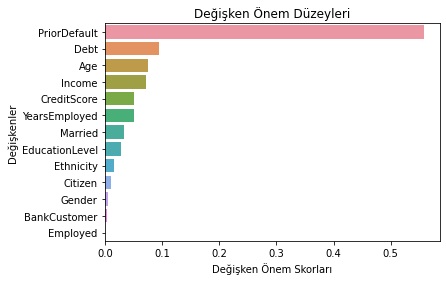

In [ ]:
feature_imp = pd.Series(gbm_tuned.feature_importances_,
                        index = X_train.columns).sort_values(ascending=False)
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Değişken Önem Skorları")
plt.ylabel("Değişkenler")
plt.title("Değişken Önem Düzeyleri")
plt.show()

# XGBoost

### Model & Tahmin

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
xgb_model = XGBClassifier().fit(X_train, y_train)
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [231]:
y_pred = xgb_model.predict(X_test)

In [232]:
accuracy_score(y_test, y_pred)

0.8357487922705314

###Model Tuning

In [ ]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb_params = {"n_estimators":[100,500,1000],
              "subsample":[0.6,0.8,1],
              "max_dept": [3,5,7],
              "learning_rate": [0.1,0.001,0.0001]}

In [ ]:
xgb_cv_model = GridSearchCV(xgb, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 641 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  2.0min finished


In [140]:
xgb_cv_model.best_params_

{'learning_rate': 0.1, 'max_dept': 3, 'n_estimators': 1000, 'subsample': 1}

In [233]:
xgb_tuned = XGBClassifier(learning_rate= 0.001, max_dept= 7, n_estimators= 500, subsample= 0.6).fit(X_train, y_train)

In [234]:
y_pred = xgb_tuned.predict(X_test)

In [235]:
accuracy_score(y_test, y_pred)

0.8454106280193237

### Değisken Önem Düzeyleri

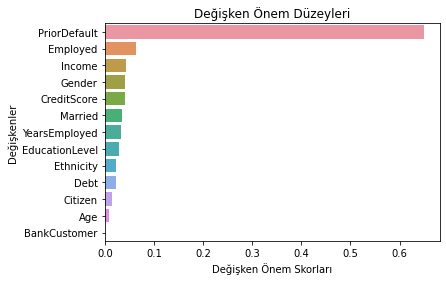

In [144]:
feature_imp = pd.Series(xgb_tuned.feature_importances_,
                        index = X_train.columns).sort_values(ascending=False)
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Değişken Önem Skorları")
plt.ylabel("Değişkenler")
plt.title("Değişken Önem Düzeyleri")
plt.show()

# Light GBM

### Model & Tahmin



In [145]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [146]:
lgbm_model = LGBMClassifier().fit(X_train, y_train)
lgbm_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [147]:
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8405797101449275

### Model Tuning

In [148]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [149]:
lgbm = LGBMClassifier()

In [150]:
lgbm_params = {"learning_rate": [0.001,0.01,0.1],
               "n_estimators":[200,500,100],
               "max_depth":[1,5,35,8]}

In [151]:
lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   21.8s finished


In [152]:
lgbm_cv_model.best_params_

{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 500}

In [236]:
lgbm_tuned = LGBMClassifier(learning_rate= 0.001, max_depth= 1, n_estimators= 500).fit(X_train, y_train)

In [237]:
y_pred = lgbm_tuned.predict(X_test)

In [238]:
accuracy_score(y_test, y_pred)

0.8405797101449275

### Değisken Önem Düzeyleri

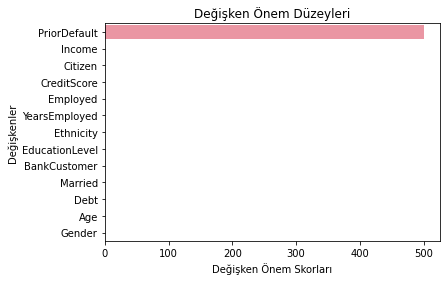

In [156]:
feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index = X_train.columns).sort_values(ascending=False)
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Değişken Önem Skorları")
plt.ylabel("Değişkenler")
plt.title("Değişken Önem Düzeyleri")
plt.show()

# CatBoost

### Model & Tahmin

In [157]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [158]:
catb_model = CatBoostClassifier().fit(X_train, y_train, verbose=False)
catb_model

In [159]:
y_pred = catb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8743961352657005

### Model Tuning

In [160]:
y = df["Approved"] 
X = df.drop(["Approved"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [161]:
catb = CatBoostClassifier()

In [162]:
catb_params = {"iterations": [200,500,100],
               "learning_rate":[0.1,0.01,0.03],
               "depth":[4,6,8]}

In [ ]:
catb_cv_model = GridSearchCV(catb, catb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

In [164]:
catb_cv_model.best_params_

{'depth': 8, 'iterations': 200, 'learning_rate': 0.03}

In [ ]:
catb_tuned = CatBoostClassifier(iterations= 200, learning_rate= 0.03, depth= 8).fit(X_train, y_train)

In [240]:
y_pred = catb_tuned.predict(X_test)

In [241]:
accuracy_score(y_test, y_pred)

0.8695652173913043

### Değisken Önem Düzeyleri

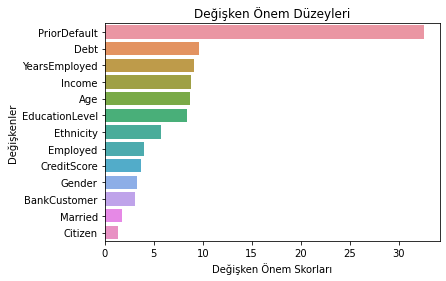

In [168]:
feature_imp = pd.Series(catb_tuned.feature_importances_,
                        index = X_train.columns).sort_values(ascending=False)
sns.barplot(x = feature_imp, y = feature_imp.index)
plt.xlabel("Değişken Önem Skorları")
plt.ylabel("Değişkenler")
plt.title("Değişken Önem Düzeyleri")
plt.show()

## MODEL SONUÇLARININ KARŞILAŞTIRILMASI

In [242]:
modeller = [knn_tuned,log_model,svm_tuned,xgb_tuned,mlpc_tuned,cart_tuned, rf_tuned, gbm_tuned, catb_tuned, lgbm_tuned, xgb_tuned]

sonuc = []
sonuclar = pd.DataFrame(columns = ["Modeller", "Accuracy"])     

for model in modeller:
  isimler = model.__class__.__name__
  y_pred = model.predict(X_test)
  dogruluk = accuracy_score(y_test, y_pred)
  sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns = ["Modeller", "Accuracy"])
  sonuclar = sonuclar.append(sonuc)

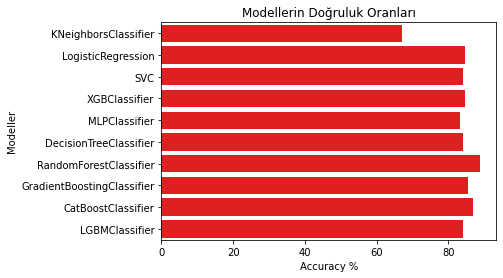

In [243]:
sns.barplot(x='Accuracy', y='Modeller', data=sonuclar, color='r')
plt.xlabel('Accuracy %')
plt.title('Modellerin Doğruluk Oranları');

In [244]:
sonuclar

,Modeller,Accuracy
0,KNeighborsClassifier,67.149758
0,LogisticRegression,84.541063
0,SVC,84.057971
0,XGBClassifier,84.541063
0,MLPClassifier,83.091787
0,DecisionTreeClassifier,84.057971
0,RandomForestClassifier,88.888889
0,GradientBoostingClassifier,85.507246
0,CatBoostClassifier,86.956522
0,LGBMClassifier,84.057971
